In [2]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

In this notebook, I will generate statistics based on heterozygosity, and correlate it with call_rate/coverage.
I will also identify stretches of homozygosity (percentage of 10kb windows, and runs longer than 1Mb).
First, I will do an example run with anubis, followed by setting up an automated approach.

In [3]:
# Standardized parts.
short_form = "Papio"
long_form = "Papio_papio_ssp"
size_cutoff = 1000000
window_size = 10000 # Should maybe decrease to 25 or 10kb.

metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
metadata_df = pd.read_csv(metadata_path+"{}_individuals.txt".format(short_form), sep="\t")
metadata_df["SEX_I"] = [0 if x == "F" else 1 for x in metadata_df.GENETIC_SEX]

In [5]:
regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
regions_df["LENGTH"] = regions_df["END"]-regions_df["START"]
large_contigs = regions_df.loc[(regions_df.LENGTH >= 1000000) & (regions_df.FEMALE_PLOIDY == 2)].CONTIG_ID.unique()
large_x = regions_df.loc[(regions_df.LENGTH >= 1000000) & (regions_df.FEMALE_PLOIDY == 2) &
                        (regions_df.MALE_PLOIDY == 1)].CONTIG_ID

In [6]:
regions_df

,REFERENCE_FOLDER,REGION,CONTIG_ID,START,END,BATCH,FEMALE_PLOIDY,MALE_PLOIDY,LENGTH
0,Papio_anubis_ssp,NC_044976.1,NC_044976.1,0,218172882,0,2,2,218172882
1,Papio_anubis_ssp,NC_044977.1,NC_044977.1,0,193660750,1,2,2,193660750
2,Papio_anubis_ssp,NC_044978.1,NC_044978.1,0,184919515,2,2,2,184919515
3,Papio_anubis_ssp,NC_044979.1,NC_044979.1,0,182120902,3,2,2,182120902
4,Papio_anubis_ssp,NC_044980.1,NC_044980.1,0,173900761,4,2,2,173900761
...,...,...,...,...,...,...,...,...,...
9298,Papio_anubis_ssp,NW_022170217.1,NW_022170217.1,0,28558,25,2,2,28558
9299,Papio_anubis_ssp,NW_022170225.1,NW_022170225.1,0,28535,25,2,2,28535
9300,Papio_anubis_ssp,NW_022170233.1,NW_022170233.1,0,28521,25,2,2,28521
9301,Papio_anubis_ssp,NW_022170241.1,NW_022170241.1,0,28516,25,2,2,28516


In [5]:
ds = sg.load_dataset("../data/{}".format(long_form))
sex_map = dict(zip(metadata_df.GVCF_ID,metadata_df.SEX_I))
ds["sample_cohort"] = xr.DataArray(pd.Series(ds.sample_id.values).map(sex_map), dims="samples")

In [6]:
# Translating chosen contigs to callset_ID.
contig_IDs = pd.Series(large_contigs).map(dict(zip(ds.contig_id.values, range(len(ds.contig_id.values))))).values
#large_contigs.values
ds_autx = ds.sel(variants=(ds.variant_contig.isin(contig_IDs).compute()), contigs=contig_IDs)

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:261: RuntimeWarning: invalid value encountered in cohort_nanmean
  return self.ufunc(*args, **kwargs)


In [7]:
bed_path_x = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/{}/filteredVCF/pos_bed_cov_based/{}_batch*_fploidy2_mploidy1.bed".format(long_form, long_form)
bed_path_all = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/{}/filteredVCF/pos_bed_cov_based/{}_batch*_fploidy2_mploidy2.bed".format(long_form, long_form)

bed_l = []
for b in glob.glob(bed_path_x):
    bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
    bed_l.append(bed_file)
bed_x = pd.concat(bed_l)

bed_l = []
for b in glob.glob(bed_path_all):
    bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
    bed_l.append(bed_file)
bed_files = pd.concat(bed_l)
bed_files = bed_files.loc[~(bed_files.chrom.isin(bed_x.chrom.unique()))]
bed_files = pd.concat([bed_files, bed_x]).sort_values(by=["chrom", "start", "end"])

In [8]:
ds_autx = sg.window_by_position(ds_autx, size=window_size)
ds_autx

<xarray.Dataset> Size: 6GB
Dimensions:                  (windows: 27352, variants: 7664092, samples: 14,
                              alleles: 2, genotypes: 3, ploidy: 2, contigs: 21,
                              filters: 2, region_index_values: 13004,
                              region_index_fields: 6)
Coordinates:
  * samples                  (samples) int64 112B 0 1 2 3 4 5 ... 9 10 11 12 13
Dimensions without coordinates: windows, variants, alleles, genotypes, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/55)
    window_contig            (windows) int64 219kB 0 0 0 0 0 ... 20 20 20 20 20
    window_start             (windows) int64 219kB 0 237 615 ... 7663704 7664090
    window_stop              (windows) int64 219kB 237 615 ... 7664090 7664092
    call_AD                  (variants, samples, alleles) int16 429MB dask.array<chunksize=(999, 14, 2), meta=np.ndarray>
    call_DP                  (variants, samples) int16 215MB dask.array<chunksize=(999, 14), meta=np.ndarray>
    call_GQ                  (variants, samples) int8 107MB dask.array<chunksize=(999, 14), meta=np.ndarray>
    ...                       ...
    variant_id               (variants) object 61MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask          (variants) bool 8MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length           (variants) int16 15MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position         (variants) int32 31MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality          (variants) float32 31MB dask.array<chunksize=(999,), meta=np.ndarray>
    sample_cohort            (samples) int64 112B 0 0 0 0 0 1 1 1 1 1 1 1 1 0
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [9]:
ds_autx

<xarray.Dataset> Size: 6GB
Dimensions:                  (windows: 27352, variants: 7664092, samples: 14,
                              alleles: 2, genotypes: 3, ploidy: 2, contigs: 21,
                              filters: 2, region_index_values: 13004,
                              region_index_fields: 6)
Coordinates:
  * samples                  (samples) int64 112B 0 1 2 3 4 5 ... 9 10 11 12 13
Dimensions without coordinates: windows, variants, alleles, genotypes, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/55)
    window_contig            (windows) int64 219kB 0 0 0 0 0 ... 20 20 20 20 20
    window_start             (windows) int64 219kB 0 237 615 ... 7663704 7664090
    window_stop              (windows) int64 219kB 237 615 ... 7664090 7664092
    call_AD                  (variants, samples, alleles) int16 429MB dask.array<chunksize=(999, 14, 2), meta=np.ndarray>
    call_DP                  (variants, samples) int16 215MB dask.array<chunksize=(999, 14), meta=np.ndarray>
    call_GQ                  (variants, samples) int8 107MB dask.array<chunksize=(999, 14), meta=np.ndarray>
    ...                       ...
    variant_id               (variants) object 61MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask          (variants) bool 8MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length           (variants) int16 15MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position         (variants) int32 31MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality          (variants) float32 31MB dask.array<chunksize=(999,), meta=np.ndarray>
    sample_cohort            (samples) int64 112B 0 0 0 0 0 1 1 1 1 1 1 1 1 0
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [10]:
sg.sample_stats(ds_autx).sample_call_rate.values # Not a good example of variability in call rate.

array([0.98925378, 0.98587948, 0.99053078, 0.98941049, 0.98933703,
       0.96263236, 0.96295595, 0.96301349, 0.96251467, 0.96383485,
       0.96462255, 0.96300305, 0.92897645, 0.90889697])

In [11]:
ds_autx_diversity = sg.diversity(ds_autx.chunk({"variants": 50000}))

In [12]:
def pos_windows(bed_l, window_size, chrom_order):
    # Input a bed file and the window size of intervals desired. Multiple chromosomes accepted.
    # It has to be sorted.
    df_l = []
    for c in chrom_order:
        print(c)
        frac_l = []
        b = bed_l.loc[bed_l["chrom"] == c].copy()
        b["w_s"] = b.end-b.start
        w_start = b.start.iloc[0]
        current_pos, callable_bases = 0, 0
        for i, j, k in zip(b.start, b.end, b.w_s):
            # Nothing called in the current window under investigation.
            while i-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
            # Window starts in current. We know this is true because of the previous while loop.
            callable_bases += min(k, current_pos+window_size-i)
            # Everything called in current.
            while j-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
                if j-window_size >= current_pos:
                    callable_bases += window_size
                else:
                # Window stops in current. Again, know this is true.
                    callable_bases += j-current_pos
        # Last window.
        frac_l.append(callable_bases/(window_size))
        df_l.append(pd.DataFrame({"chrom": c, "window_start": list(range(0, len(frac_l)*window_size, window_size)),
                                  "window_end": list(range(window_size, (len(frac_l)+1)*window_size, window_size)),
                                  "callable_frac": frac_l}))
    return pd.concat(df_l)

In [13]:
kept_contigs =  [x for x in ds.contig_id.values if (x == large_contigs).any()]

contig_l, window_start_l = [], []
v_c = pd.Series(ds_autx_diversity.window_contig).value_counts(sort=False)
for i in range(len(v_c)):
    window_start_l.extend(list(range(0, v_c[i]*window_size, window_size)))
    contig_l.extend([kept_contigs[i]]*v_c[i])
window_df = pd.DataFrame({"chrom": contig_l, "window_start": window_start_l})

intervals_callable = pos_windows(bed_files, window_size, kept_contigs)

NC_044976.1
NC_044977.1
NC_044978.1
NC_044979.1
NC_044980.1
NC_044981.1
NC_044982.1
NC_044983.1
NC_044984.1
NC_044985.1
NC_044986.1
NC_044987.1
NC_044988.1
NC_044989.1
NC_044990.1
NC_044991.1
NC_044992.1
NC_044993.1
NC_044994.1
NC_044995.1
NC_044996.1


In [14]:
window_df_call = window_df.merge(intervals_callable, on=["chrom", "window_start"])
window_df_call["diversity"] = ds_autx_diversity["stat_diversity"][:,1].values

In [15]:
intervals_callable_chrX = window_df_call.loc[(window_df_call["chrom"] == bed_x.chrom.unique()[0]) &
                                                (window_df_call.callable_frac >= 0.95)].copy()
intervals_callable_aut = window_df_call.loc[(window_df_call["chrom"] != bed_x.chrom.unique()[0]) &
                                               (window_df_call.callable_frac >= 0.95)].copy()

In [16]:
intervals_callable_chrX["quantile_bin"] = pd.qcut(intervals_callable_chrX.diversity, 10)
div_bin_x = intervals_callable_chrX.groupby(["quantile_bin"])["diversity"].mean().reset_index()["diversity"]
intervals_callable_aut["quantile_bin"] = pd.qcut(intervals_callable_aut.diversity, 10)
div_bin_aut = intervals_callable_aut.groupby(["quantile_bin"])["diversity"].mean().reset_index()["diversity"]

/tmp/1423843/ipykernel_167986/2687425363.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  div_bin_x = intervals_callable_chrX.groupby(["quantile_bin"])["diversity"].mean().reset_index()["diversity"]
/tmp/1423843/ipykernel_167986/2687425363.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  div_bin_aut = intervals_callable_aut.groupby(["quantile_bin"])["diversity"].mean().reset_index()["diversity"]


<Axes: ylabel='diversity'>

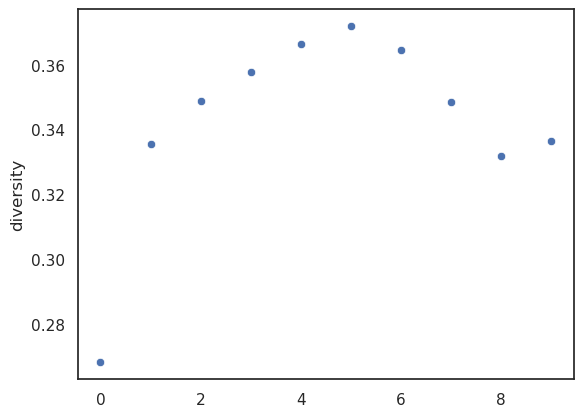

In [17]:
sns.scatterplot(y=div_bin_x/div_bin_aut, x=range(len(div_bin_x)))

In [19]:
het_stats = ds_autx
het_stats = sg.window_by_position(het_stats, size=window_size)
het_stats["sample_cohort"] = het_stats["samples"]
het_stats["call_genotype"] = het_stats["call_genotype"].clip(0)
het_stats = sg.diversity(het_stats.chunk({"variants": 50000}))

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/sgkit/utils.py:222: MergeWarning: The following variables in the input dataset will be replaced in the output: window_contig, window_start, window_stop
  warnings.warn(


In [20]:
het_df = pd.DataFrame(het_stats["stat_diversity"], columns=het_stats.sample_id)

In [21]:
window_df_het = window_df_call.join(het_df)

In [22]:
window_df_het = window_df_het.loc[window_df_het.callable_frac >= 0.95]

In [23]:
window_df_het["chr_type"] = ["chrX" if (x == large_x).any() else "aut" for x in window_df_het["chrom"]]

In [24]:
window_df_het.groupby(["chr_type"])[het_stats.sample_id.values].mean().reset_index()
# Note that male sites called as 1/. get turned into 1/0, and therefore have a very high chrX heterozygosity.
# In the full workflow, remove sites typed with 1/. for all individuals.

,chr_type,SAMEA112483028,SAMEA112483029,SAMEA112483030,SAMEA112483031,SAMEA112483032,SAMEA112483033,SAMEA112483034,SAMEA112483035,SAMEA112483036,SAMEA112483037,SAMEA112483038,SAMEA112483039,SAMN02866416,SAMN03073711
0,aut,45.357823,40.049606,46.615515,45.756654,45.952229,45.797710,45.990919,45.244506,46.069507,43.650292,45.812732,45.275902,53.014442,35.694296
1,chrX,15.655374,17.996495,16.538551,16.082944,16.064252,108.258178,108.531542,108.238318,107.816589,108.054907,108.063084,108.147196,104.908879,18.716121


Standardized workflow implementation - going to write it here and then implement it as a python script for scalablity.

In [2]:
# Standardized parts.
size_cutoff = 1000000
window_size = 100000 # Should maybe decrease to 25 or 10kb.

In [3]:
# Current sgkit paths:
glob.glob("../data/*/")

['../data/Papio_papio_ssp/',
 '../data/Gorilla_gorilla_ssp/',
 '../data/Papio_cynocephalus_ssp/',
 '../data/Papio_anubis_ssp/',
 '../data/Pongo_pygmaeus/',
 '../data/Pan_troglodytes_troglodytes/']

Functions for the standardized analysis.

In [4]:
def read_beds(long_form):
    bed_path_x = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/{}/filteredVCF/pos_bed_cov_based/{}_batch*_fploidy2_mploidy1.bed".format(long_form, long_form)
    bed_path_all = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/{}/filteredVCF/pos_bed_cov_based/{}_batch*_fploidy2_mploidy2.bed".format(long_form, long_form)
    bed_l = []
    for b in glob.glob(bed_path_x):
        bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
        bed_l.append(bed_file)
    bed_x = pd.concat(bed_l)

    bed_l = []
    for b in glob.glob(bed_path_all):
        bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
        bed_l.append(bed_file)
    bed_files = pd.concat(bed_l)
    bed_files = bed_files.loc[~(bed_files.chrom.isin(bed_x.chrom.unique()))]
    bed_files = pd.concat([bed_files, bed_x]).sort_values(by=["chrom", "start", "end"])
    return bed_files

def pos_windows(bed_l, window_size, chrom_order):
    # Input a bed file and the window size of intervals desired. Multiple chromosomes accepted.
    # It has to be sorted.
    df_l = []
    for c in chrom_order:
        frac_l = []
        b = bed_l.loc[bed_l["chrom"] == c].copy()
        b["w_s"] = b.end-b.start
        w_start = b.start.iloc[0]
        current_pos, callable_bases = 0, 0
        for i, j, k in zip(b.start, b.end, b.w_s):
            # Nothing called in the current window under investigation.
            while i-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
            # Window starts in current. We know this is true because of the previous while loop.
            callable_bases += min(k, current_pos+window_size-i)
            # Everything called in current.
            while j-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
                if j-window_size >= current_pos:
                    callable_bases += window_size
                else:
                # Window stops in current. Again, know this is true.
                    callable_bases += j-current_pos
        # Last window.
        frac_l.append(callable_bases/(window_size))
        df_l.append(pd.DataFrame({"chrom": c, "window_start": list(range(0, len(frac_l)*window_size, window_size)),
                                  "window_end": list(range(window_size, (len(frac_l)+1)*window_size, window_size)),
                                  "callable_frac": frac_l}))
    return pd.concat(df_l)

In [5]:
glob.glob("../data/*/")[2:-2]

['../data/Papio_cynocephalus_ssp/', '../data/Papio_anubis_ssp/']

# TODO
Also note which contigs are chromosome X or autosomes. In addition, note species and sex.

In [6]:
for x in ['../data/Papio_cynocephalus_ssp/',
 '../data/Papio_anubis_ssp/']:
    # The name used to load all the files, short and long version
    short_form = x.split("/")[-2].split("_")[0]
    long_form = x.split("/")[-2]
    print(long_form)
    # Loading the various metadata files. Metadata, contig information, callability bed.
    metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
    metadata_df = pd.read_csv(metadata_path+"{}_individuals.txt".format(short_form), sep="\t")
    metadata_df["SEX_I"] = [0 if x == "F" else 1 for x in metadata_df.GENETIC_SEX]
    regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
    regions_df["LENGTH"] = regions_df["END"]-regions_df["START"]
    large_contigs = regions_df.loc[(regions_df.LENGTH >= size_cutoff) & (regions_df.FEMALE_PLOIDY == 2)].CONTIG_ID.unique()
    large_x = regions_df.loc[(regions_df.LENGTH >= size_cutoff) & (regions_df.FEMALE_PLOIDY == 2) &
                        (regions_df.MALE_PLOIDY == 1)].CONTIG_ID
    bed_files = read_beds(long_form)
    # Loading the genetic data.
    ds = sg.load_dataset("../data/{}".format(long_form))
    sex_map = dict(zip(metadata_df.GVCF_ID, metadata_df.SEX_I))
    # If you want to split based on sex. I will make every individual unique
    #ds["sample_cohort"] = xr.DataArray(pd.Series(ds.sample_id.values).map(sex_map), dims="samples")
    ds["sample_cohort"] = ds["samples"]
    # Only keeping contigs which are above the cutoff (1Mb or more)
    kept_contigs =  [x for x in ds.contig_id.values if (x == large_contigs).any()]
    contig_IDs = pd.Series(kept_contigs).map(dict(zip(ds.contig_id.values, range(len(ds.contig_id.values))))).values
    # Subsetting and windowing the sgkit dataset. The rechunking handles what otherwise would cause an error.
    ds_autx = ds.sel(variants=(ds.variant_contig.isin(contig_IDs).compute()), contigs=contig_IDs)
    ds_autx = sg.window_by_position(ds_autx, size=window_size)
    ds_autx["call_genotype"] = ds_autx["call_genotype"].clip(0)
    ds_autx_diversity = sg.diversity(ds_autx.chunk({"variants": 50000}))
    # Generating window callability
    contig_l, window_start_l = [], []
    v_c = pd.Series(ds_autx.window_contig).value_counts(sort=False)
    for i in range(len(v_c)):
        window_start_l.extend(list(range(0, v_c[i]*window_size, window_size)))
        contig_l.extend([kept_contigs[i]]*v_c[i])
    window_df = pd.DataFrame({"chrom": contig_l, "window_start": window_start_l})
    intervals_callable = pos_windows(bed_files, window_size, kept_contigs)
    window_df_call = window_df.merge(intervals_callable, on=["chrom", "window_start"])
    # Merge and save
    output_df = pd.merge(window_df_call, pd.DataFrame(ds_autx_diversity["stat_diversity"],
                                      columns=ds_autx_diversity["sample_id"]),
                         left_index=True, right_index=True)
    output_df.to_csv("../results/window_stats/{}_100kb_het.txt".format(long_form), sep="\t")

Papio_cynocephalus_ssp
Papio_anubis_ssp


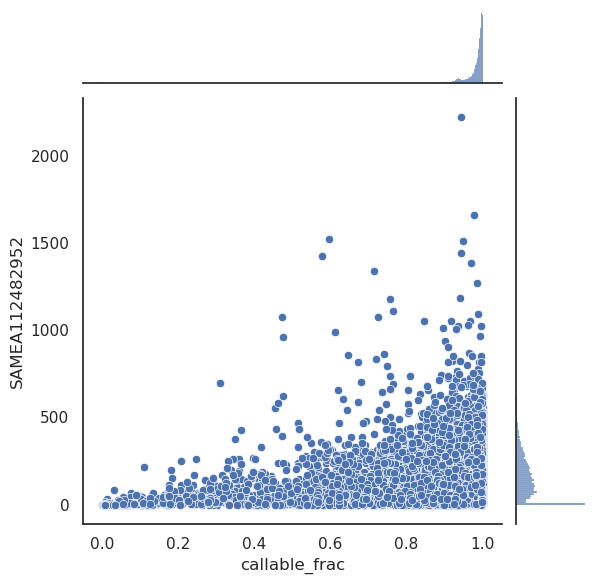

In [9]:
sns.jointplot(data=output_df, x="callable_frac", y="SAMEA112482952")